In [1]:
from yahoo_fin.stock_info import get_data, tickers_sp500, tickers_nasdaq, tickers_other, get_quote_table
import matplotlib.pylab as plt

In [2]:
sp500 = tickers_sp500()
#print(sp500)

In [3]:
import pickle
sp500Dict = {}
'''
It takes a while to get quote tables for alls sp500 stocks.
Once it is loaded, I will save a copy for the future usage.
'''
try:
    sp500Dict = pickle.load(open("sp500.p", "rb"))
except:
    for ticker in sp500:
        try:
            sp500Dict[ticker] = get_quote_table(ticker)
            print(ticker + " is added.")
        except:
            print(ticker + " is skipped for some reason")
pickle.dump(sp500Dict, open("sp500.p", "wb"))
#print(sp500Dict)

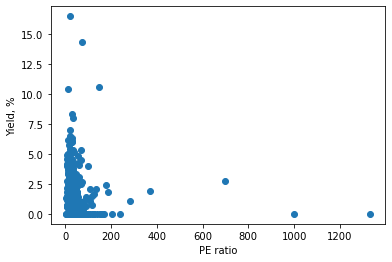

In [4]:
'''
Plot the data as a QC
'''
import numpy as np
x = np.zeros(len(sp500Dict)) # PE ratio
y = np.zeros(len(sp500Dict)) # return
index = 0
for stock in sp500Dict.keys():
    peRatio = sp500Dict[stock]['PE Ratio (TTM)']
    try:
        peRatio = float(peRatio)
    except:
        peRatio = 0
    divYield = sp500Dict[stock]['Forward Dividend & Yield']
    try:
        divYield = float(divYield.split(" ")[0])
    except:
        divYield = 0
    x[index] = peRatio
    y[index] = divYield
    index = index + 1
plt.plot(x,y, 'o')
plt.xlabel("PE ratio")
plt.ylabel("Yield, %")
plt.show()

In [5]:
'''
Test the historical price based clustering method
'''
amzn = get_data("amzn", start_date = "01/01/2020", end_date = "01/31/2020")
print(amzn)
print(type(amzn)) # panda dataframe format
print(amzn.to_numpy()[:,1])

                   open         high          low        close     adjclose  \
2020-01-02  1875.000000  1898.010010  1864.150024  1898.010010  1898.010010   
2020-01-03  1864.500000  1886.199951  1864.500000  1874.969971  1874.969971   
2020-01-06  1860.000000  1903.689941  1860.000000  1902.880005  1902.880005   
2020-01-07  1904.500000  1913.890015  1892.040039  1906.859985  1906.859985   
2020-01-08  1898.040039  1911.000000  1886.439941  1891.969971  1891.969971   
2020-01-09  1909.890015  1917.819946  1895.800049  1901.050049  1901.050049   
2020-01-10  1905.369995  1906.939941  1880.000000  1883.160034  1883.160034   
2020-01-13  1891.310059  1898.000000  1880.800049  1891.300049  1891.300049   
2020-01-14  1885.880005  1887.109985  1858.550049  1869.439941  1869.439941   
2020-01-15  1872.250000  1878.859985  1855.089966  1862.020020  1862.020020   
2020-01-16  1882.989990  1885.589966  1866.020020  1877.939941  1877.939941   
2020-01-17  1885.890015  1886.640015  1857.250000  1

In [6]:
%load_ext autoreload
%autoreload 2
import stockPriceClean as sc
test = sc.stockPriceClean(amzn) # method to clean the data
print(test.get())
print(len(test.get()))

[1.2272005208333334 0.5615430787409493 2.3053766066028225
 0.12391626944407981 -0.3198071818534024 -0.4628520884716869
 -1.1656508181831635 -0.0005292503775104217 -0.8717449378537779
 -0.5464003455067432 -0.26819307879042004 -1.122549235685887
 1.447721179624665 -0.45514743700881666 -0.028116624546771603
 -1.5718754419019931 0.45823988023695056 0.6927465362673186
 -0.3218884120171674 0.6824571426769376]
20


In [7]:
from sklearn.cluster import KMeans
import numpy as np
'''
import the kmeans module
'''

'\nimport the kmeans module\n'

In [9]:
stockList = []
counter = 0
tradingDays = 20 # 20 trading days from 1/1 to 1/31
stockData = np.zeros(tradingDays) # each stock has tradingDays of dimension
for stock in sp500Dict.keys():
    if counter > 10: # small sample size for testing purpose
        break
    try:
        greppedData = sc.stockPriceClean(get_data(stock, start_date = "01/01/2020", end_date = "01/31/2020"))
        stockList = stockList + [stock]
        if counter == 0:
            stockData = greppedData.get()
        else:
            stockData = np.vstack((stockData, greppedData.get()))
        counter = counter + 1
    except:
        print(key + ": cannot get data")
#print(stockList)  
#print(stockData)

In [21]:
'''
Test K-means with 20 dimensions
'''
kmeans = KMeans(n_clusters=3, random_state=0).fit(stockData)
stockLabel = kmeans.labels_

A: group b
AAL: group c
AAP: group b
AAPL: group b
ABBV: group b
ABC: group b
ABMD: group k
ABT: group b
ACN: group b
ADBE: group b
ADI: group b


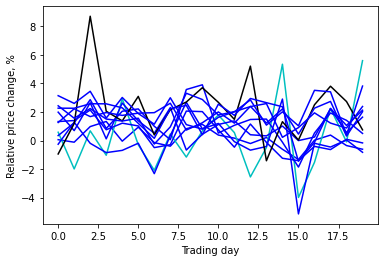

In [24]:
x = np.arange(20)
color = ['b', 'c', 'k', 'g', 'r', 'm', 'y']
for i in range(counter):
    plt.plot(x, stockData[i] + i * 0.2, c = color[stockLabel[i]], label = stockList[i])
    print(stockList[i] + ": group " + color[stockLabel[i]])
plt.ylabel("Relative price change, %")
plt.xlabel("Trading day")
#plt.legend()
plt.show()

The result makes sense. ABMD has a huge increase on day 2 and AAL has a unique drop on day 11. So these two stocks are assigned to different groups.

In [28]:
'''
Prepare data for the whole sp500 stocks
'''
stockList = []
counter = 0
tradingDays = 20 # 20 trading days from 1/1 to 1/31
stockData = np.zeros(tradingDays) # each stock has tradingDays of dimension
try:
    stockList = pickle.load(open("stockList.p", "rb"))
    stockData = pickle.load(open("stockData.p", "rb"))
    counter = len(stockList)
except:
    print("Cannot locate the files, generating new files")
    for stock in sp500Dict.keys():
        try:
            greppedData = sc.stockPriceClean(get_data(stock, start_date = "01/01/2020", end_date = "01/31/2020"))
            stockList = stockList + [stock]
            if counter == 0:
                stockData = greppedData.get()
            else:
                stockData = np.vstack((stockData, greppedData.get()))
            counter = counter + 1
        except:
            print(stock + ": cannot get data")
    pickle.dump(stockList, open("stockList.p", "wb"))
    pickle.dump(stockData, open("stockData.p", "wb"))

Cannot locate the files, generating new files
CARR: cannot get data
OTIS: cannot get data
VNT: cannot get data
WRK: cannot get data


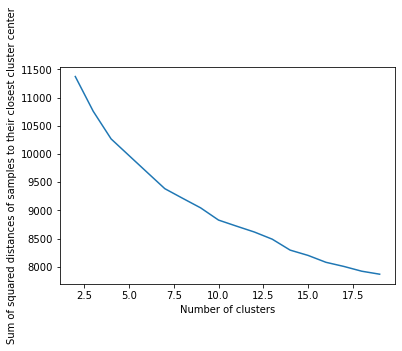

In [31]:
'''
Test what is the best number of clusters for this specific case.
The value does not converge well
'''
n = range(2,20)
inertia = []
for numOfClusters in n:
    kmeans = KMeans(n_clusters=numOfClusters, random_state=0).fit(stockData)
    inertia = inertia + [kmeans.inertia_]
plt.plot(n, inertia)
plt.xlabel("Number of clusters")
plt.ylabel("Sum of squared distances of samples to their closest cluster center")
plt.show()